In [1]:
# 1. Imports and Setup
import sys, os
sys.path.append(os.path.abspath(".."))
from notebook_setup import *
tracker = ExperimentTracker()

Checking dependencies in src/config.py...
  -> Chronos: True
  -> TimeGPT: True
  -> API Key: Found
Notebook setup complete.


Dataset: ECB EUR/CZK Monthly Exchange Rate
Total: 385 | Train: 361 | Test: 24
Train period: 1993-12-01 to 2023-12-01
Test period:  2024-01-01 to 2025-12-01
Seasonal period: 12


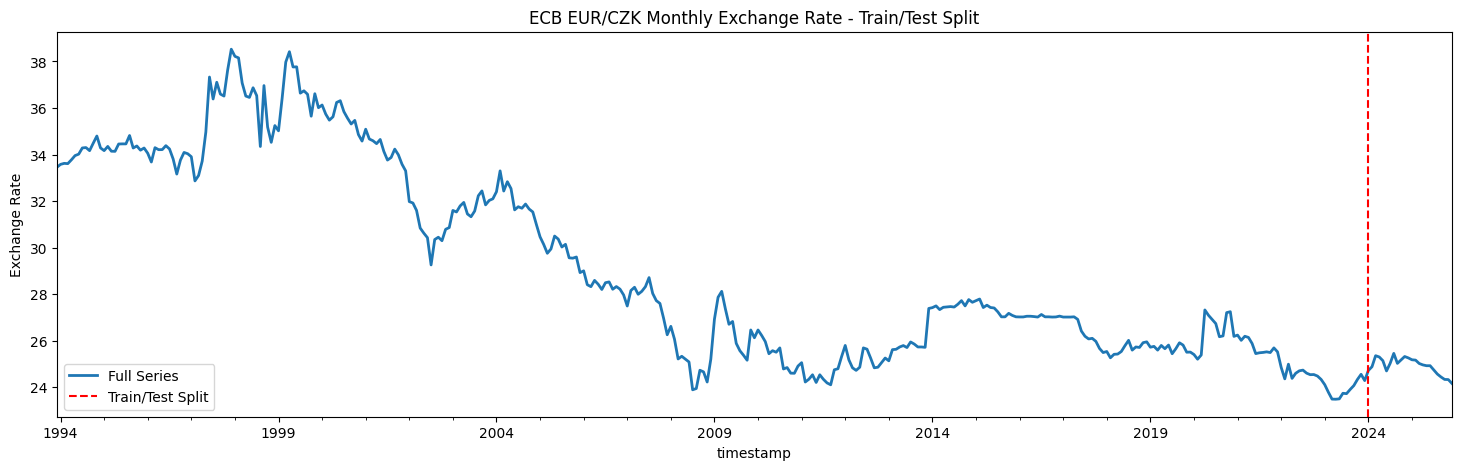

In [2]:
# 2. Data Loading and Configuration
#
# DATASET_CONFIG serves as a template for different datasets.
# Simply uncomment the desired configuration or create a new one.

# === ACTIVE DATASET CONFIGURATION ===
DATASET_CONFIG = {
    "file_path": "../datasets/ecb_eurczk_monthly.csv",
    "time_column": "timestamp",
    "target_column": "eur_czk",
    "frequency": "MS",  # 'MS'=monthly start, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    "test_periods": 24,  # Number of periods to hold out for testing
    "seasonal_period": 12,  # 12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily
    "name": "ECB EUR/CZK Monthly Exchange Rate",
    "value_unit": "Exchange Rate",  # Y-axis label for charts
}

# === LOAD AND PREPROCESS DATA ===
df = pd.read_csv(DATASET_CONFIG["file_path"])
df[DATASET_CONFIG["time_column"]] = pd.to_datetime(df[DATASET_CONFIG["time_column"]])
series = TimeSeries.from_dataframe(
    df, DATASET_CONFIG["time_column"], DATASET_CONFIG["target_column"]
)
series = series.astype(np.float32)

# === TRAIN/TEST SPLIT ===
# Test set is held out completely - models never see it during training or validation
freq = DATASET_CONFIG["frequency"]
test_periods = DATASET_CONFIG["test_periods"]
offset_map = {
    "MS": pd.DateOffset(months=test_periods),
    "QS": pd.DateOffset(months=test_periods * 3),
    "YS": pd.DateOffset(years=test_periods),
    "D": pd.DateOffset(days=test_periods),
    "H": pd.DateOffset(hours=test_periods),
}
offset = offset_map.get(freq, pd.DateOffset(days=test_periods))

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# === SCALING (for Deep Learning models) ===
# IMPORTANT: Scaler is fitted ONLY on training data to prevent data leakage
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)  # Transform only, no fitting
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Total: {len(series)} | Train: {len(train)} | Test: {len(test)}")
print(f"Train period: {train.start_time().date()} to {train.end_time().date()}")
print(f"Test period:  {test.start_time().date()} to {test.end_time().date()}")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label="Full Series", figsize=(18, 5))
plt.axvline(x=test.start_time(), color="red", linestyle="--", label="Train/Test Split")
plt.title(f"{DATASET_CONFIG['name']} - Train/Test Split")
plt.ylabel(DATASET_CONFIG.get("value_unit", DATASET_CONFIG["target_column"]))
plt.legend()
plt.show()

In [3]:
# 3. Hyperparameter Tuning

SEASONAL_PERIOD = DATASET_CONFIG["seasonal_period"]
stat_grids = get_statistical_grids(SEASONAL_PERIOD)
dl_grids = get_dl_grids(SEASONAL_PERIOD)

In [4]:
# 4. Statistical Models

# Holt-Winters
run_tuning_and_eval(
    tracker,
    "Holt-Winters",
    ExponentialSmoothing,
    stat_grids["Holt-Winters"],
    train,
    use_full_grid=True,
    test_periods=DATASET_CONFIG["test_periods"],
)

# AutoARIMA
AutoARIMA()
run_tuning_and_eval(
    tracker,
    "AutoARIMA",
    AutoARIMA,
    stat_grids["AutoARIMA"],
    train,
    use_full_grid=True,
    test_periods=DATASET_CONFIG["test_periods"],
)


# Prophet
Prophet()
run_tuning_and_eval(
    tracker,
    "Prophet",
    Prophet,
    stat_grids["Prophet"],
    train,
    use_full_grid=True,
    test_periods=DATASET_CONFIG["test_periods"],
)

Holt-Winters: 100%|██████████| 15/15 [01:23<00:00,  5.56s/it, best=1.07, rmse=1.32]


Holt-Winters: RMSE=1.0742 | MAPE=3.45% | Time=83.5s (15 combinations)


AutoARIMA: 100%|██████████| 1/1 [00:13<00:00, 13.64s/it, best=inf, rmse=1.32]


AutoARIMA: RMSE=1.3213 | MAPE=4.35% | Time=13.6s (1 combinations)


Prophet: 100%|██████████| 6/6 [00:48<00:00,  8.03s/it, best=1.74, rmse=2.21]

Prophet: RMSE=1.7428 | MAPE=5.05% | Time=48.2s (6 combinations)


{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01}

In [5]:
# 5. Deep Learning Models

# TiDE
run_tuning_and_eval(
    tracker,
    "TiDE",
    TiDEModel,
    dl_grids["TiDE"],
    train_scaled,
    is_dl=True,
    n_iter=TUNING_CONFIG["N_ITER"],
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

# N-BEATS
run_tuning_and_eval(
    tracker,
    "N-BEATS",
    NBEATSModel,
    dl_grids["N-BEATS"],
    train_scaled,
    is_dl=True,
    n_iter=TUNING_CONFIG["N_ITER"],
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

# TFT
run_tuning_and_eval(
    tracker,
    "TFT",
    TFTModel,
    dl_grids["TFT"],
    train_scaled,
    is_dl=True,
    n_iter=TUNING_CONFIG["N_ITER"],
    scaler=scaler,
    original_train=train,
    test_periods=DATASET_CONFIG["test_periods"],
)

TiDE: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, best=0.98, rmse=0.98]


TiDE: RMSE=0.9760 | MAPE=2.98% | Time=3.3s (4 combinations)


N-BEATS: 100%|██████████| 4/4 [00:09<00:00,  2.46s/it, best=0.97, rmse=1.01]


N-BEATS: RMSE=0.9713 | MAPE=2.97% | Time=9.8s (4 combinations)


TFT: 100%|██████████| 4/4 [00:12<00:00,  3.25s/it, best=3.15, rmse=2.58]

TFT: RMSE=2.5767 | MAPE=6.84% | Time=13.0s (4 combinations)


{'input_chunk_length': 24,
 'output_chunk_length': 12,
 'n_epochs': 15,
 'batch_size': 32,
 'random_state': 42,
 'hidden_size': 64,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [6]:
# 6. Foundation Models (Chronos, TimeGPT)

run_foundation_models(tracker, train, test, DATASET_CONFIG["frequency"])

Chronos: RMSE=0.6867 | MAPE=2.50% | Time=2.0s (1 combinations)
TimeGPT: RMSE=0.7975 | MAPE=2.84% | Time=1.5s (1 combinations)


In [7]:
# 7. Results Comparison (Cross-Validation Metrics)

results_df = tracker.get_results_df()
print("=== Cross-Validation Results ===")
print(
    results_df[
        ["Model", "RMSE", "MAPE", "Tuning Time (s)", "Combinations"]
    ].to_string(index=False)
)

=== Cross-Validation Results ===
       Model     RMSE     MAPE  Tuning Time (s)  Combinations
     Chronos 0.686724 2.497415         2.000443             1
     TimeGPT 0.797468 2.837711         1.464765             1
     N-BEATS 0.971326 2.971405         9.845426             4
        TiDE 0.976041 2.983054         3.262626             4
Holt-Winters 1.074155 3.446775        83.474642            15
   AutoARIMA 1.321255 4.350382        13.642157             1
     Prophet 1.742781 5.053059        48.202015             6
         TFT 2.576724 6.841747        12.991300             4


In [8]:
# 8. Final Predictions with Best and Fastest Models

final_predictions = get_final_predictions(
    tracker, train, test, scaler, train_scaled, DATASET_CONFIG["frequency"]
)

Retraining Best: Chronos
Retraining Fastest: TimeGPT


In [9]:
# 9. Final Predictions with Best and Fastest Models

fig = plot_forecast_comparison(
    train,
    test,
    final_predictions,
    DATASET_CONFIG["name"],
    target_column=DATASET_CONFIG.get("target_column"),
    value_unit=DATASET_CONFIG.get("value_unit"),
)
fig.show()

In [10]:
# 10. All Models Comparison (Interactive)

fig_comparison = plot_model_comparison(
    tracker.get_results_df(),  # <--- ZDE SE BEROU DATA
    DATASET_CONFIG["name"], 
    value_unit=DATASET_CONFIG.get("value_unit")
)
fig_comparison.show()

In [11]:
# 11. Export Static PNG Images

export_plots(fig, fig_comparison, DATASET_CONFIG["name"])